In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from scipy.spatial.distance import mahalanobis,euclidean
from sklearn import metrics

# Load data

In [2]:
batch_num = 1
hidden_num = 15
step_num = 84
elem_num = 1
init_wins = 12
acc_size = 3*step_num #vn1 size, used for estimating mu and sigma during initialization
power = pd.read_csv("C:/Users/Bin/Desktop/Thesis/dataset/power.csv",names=["power_demand","label"],skiprows=step_num*init_wins)
test_set = power.power_demand
labels = power.label
wins = power.shape[0]//step_num
test_set_list = [test_set.as_matrix().reshape(wins,batch_num,step_num,elem_num)[a] for a in range(wins)]


In [3]:
# figure out anomaly windows
buffer = [labels[i*step_num:(i+1)*step_num] for i in range(0,labels.size//step_num)]
anomaly_index = []
count = 0
for buf in buffer:
    if "anomaly" in buf.tolist():
        anomaly_index.append(count)
    else:
        pass
    count +=1
print(anomaly_index)

expert = ["normal"]*wins
for x in anomaly_index:
    expert[x] = "anomaly"

[0, 4, 5, 7, 26, 38]


# Load Model

In [34]:
modelpath_root ="C:/Users/Bin/Desktop/Thesis/models/power/"
modelmeta_p = modelpath_root + "_1_15_84_para.ckpt.meta"

sess = tf.Session()
saver = tf.train.import_meta_graph(modelmeta_p) # load trained gragh, but without the trained parameters
saver.restore(sess,tf.train.latest_checkpoint(modelpath_root))
graph = tf.get_default_graph()

p_input = graph.get_tensor_by_name("p_input:0")
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)] 
p_is_training = graph.get_tensor_by_name("is_training_:0")

input_= tf.transpose(tf.stack(p_inputs), [1, 0, 2])    
output_ = graph.get_tensor_by_name("decoder/output_:0")

tensor_mu = graph.get_tensor_by_name("mu:0")
tensor_sigma = graph.get_tensor_by_name("sigma:0")
tensor_threshold = graph.get_tensor_by_name("threshold:0")

loss_ = graph.get_tensor_by_name("decoder/loss:0")
train_ = graph.get_operation_by_name("cond/train_")

mu = sess.run(tensor_mu)
sigma = sess.run(tensor_sigma)
threshold = sess.run(tensor_threshold)

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/models/power/_1_15_84_para.ckpt


In [5]:
print(mu,sigma,threshold)

0.0854842 0.00507233 0.00671047


# Online Phase (With expert)

In [6]:
def scoring(err,mu,sigma):
    
    scores = []
    for e in err:
        scores.append(mahalanobis(e,mu,sigma))

    return scores

In [62]:
def update_parameter(err_nbuf,err_abuf,acc_size,mu,sigma,threshold):       
        # acc_size is the amount of data that used until now for estimating mu and sigma
        print("Estimating new parameters...")
        
        current_size = len(err_nbuf)*2//3
        p = current_size/(current_size+acc_size)
        
        tmp_errBuffer = err_nbuf[:current_size]
        err_vec_array = np.array(tmp_errBuffer)
        # for univariate  data
        __mu = np.mean(err_vec_array.ravel())
        mu_new = p*__mu + (1-p)*mu

        __sigma =np.var(err_vec_array.ravel())
        sigma_new = p*__sigma + (1-p)*sigma + p*(1-p)*(mu-mu_new)*(mu-mu_new)
        
        
        _score_n = scoring(np.array(err_nbuf[current_size:]).reshape(-1,elem_num),mu_new,sigma_new) 
        _score_a = scoring(np.array(err_abuf).reshape(-1,elem_num),mu_new,sigma_new) 
        
        scores = pd.Series(_score_n + _score_a)
        label = pd.Series( ["normal"]*len(_score_n) + ["anomaly"]*len(_score_a))
        
        upper = max(np.array(_score_a).max(),np.array(_score_n).max())
        lower = min(np.array(_score_a).max(),np.array(_score_n).max())
        scala = 20
        delta = (upper-lower) / scala
        cand = (upper+lower)/2
        __threshold = 0
        result = 0
        print(np.array(_score_a).max(),np.array(_score_n).max())
        candidates = []
        for s in range(scala):
            candidates.append( cand + (s+1)*delta)
            candidates.append( cand - (s+1)*delta)
            
        for candidate in candidates:
            r = evaluate(candidate,scores,label)
            if r > result:
                result = r 
                __threshold = candidate
           

            
        threshold_new = __threshold
        print("New parameters learned!")
        
        return mu_new,sigma_new,threshold_new

In [46]:
def evaluate(threoshld,scores,label):

    beta = 1
    tp = len(set(scores[ scores > threshold].index) & set( label[label=='anomaly'].index))
    fn = len(set(scores[ scores > threshold].index) & set(label[label=='normal'].index))
    fp = len(set(scores[ scores <= threshold].index) & set( label[label=='anomaly'].index))
    tn = len(set(scores[ scores <= threshold].index) & set(label[label=='normal'].index))

    

    if tp == 0: 
        print("TP is 0.")
        return 0
    

    P = tp/(tp+fp) # reduce the number of didn't detected anomaly
    R = tp/(tp+fn) # recuce the number of normal points that predicted as abnormal
    fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
    return fbeta

In [9]:
def plot_roc(fpr,tpr,auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' %auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

TP
TN
TN
TN
TP
TP
TN
TP
TN
TN
TN
TN
TN
TN
TN
TN
TN
TN
TN
TN
TN
TN
TN
TN
TN
TN
TP
TN
TN
TN
TN
TN
TN
TN
TN
TN
TN
TN
TP


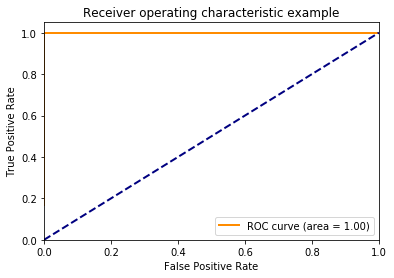

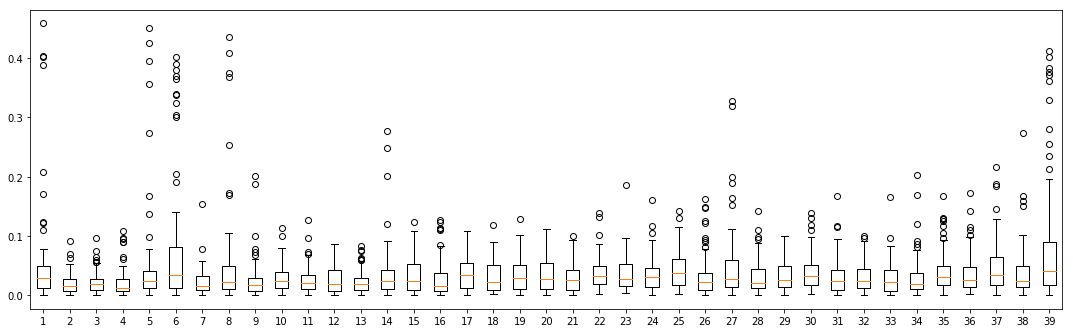

In [63]:
count = 0
n_buf = []
a_buf = []

y = []
output=[]
box = []
err_nbuf = []
err_abuf = []
all_scores = []

for l in labels:
    if l == "normal":
        y +=[0]
    else: 
        y +=[1]
for data in test_set_list:
    
        prediction = []
        
        (input_n, output_n) = sess.run([input_, output_], {p_input: data, p_is_training: False})

        err = abs(input_n-output_n).reshape(-1,elem_num)
        
        box.append(err.reshape(-1,))
        
        scores = scoring(err,mu,sigma)
        scores = pd.Series(scores)
        
        all_scores.append(scores)
        #output += [x for x in scores]
        output +=[scores[scores>threshold].size]
        pred = [scores[b*step_num:(b+1)*step_num] for b in range(batch_num)]
        label = [expert[count*batch_num+b]for b in range(batch_num)]
        e = [err.ravel()[b*step_num:(b+1)*step_num] for b in range(batch_num)]
        for index,value in enumerate(pred):
            if value[value>threshold].size>=5: 
                if label[index] == "anomaly":
                    print("TP")                 
                    a_buf.append(data[index])
                    err_abuf.append(e[index])
                else:
                    print("FP")
                    err_nbuf.append(e[index])
                    n_buf.append(data[index])
                    
            else:               
                if label[index] == "anomaly":             
                    print("FN")
                    a_buf.append(data[index])
                    err_abuf.append(e[index])
                else:
                    err_nbuf.append(e[index])
                    print("TN")
        count +=1
        

        
        if len(n_buf)>=3:
            print("retrain...")
            loss_list_all=[]

            datalist = np.array(n_buf).reshape(-1,batch_num,step_num,elem_num)
            
            for i in range(50):
                
                loss_list=[]
                for data in datalist:
                    (loss, _) = sess.run([loss_, train_], {p_input: data,p_is_training : True})
                    loss_list.append(loss)
                #print('Retrain-iter %d:' % (i + 1), np.array(loss_list).mean())
                loss_list_all.append( np.array(loss_list).mean()) 
                
            mu,sigma,threshold = update_parameter(err_nbuf,err_abuf,acc_size,mu,sigma,threshold)
            print(mu,sigma,threshold)
            pd.Series(loss_list_all).plot(title="Loss")
            n_buf = []
            err_buf = []
                
fpr, tpr, thresholds = metrics.roc_curve(expert, output, pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 5.5)
ax.boxplot(box)

plt.show()